#  Étude Approfondie : Le "Plafond de Verre" Audiovisuel (2019-2020)

### **Contexte et Problématique**
Cette analyse explore les données de l'**INA** et de l'**ARCOM** sur la parité du temps de parole. Bien au-delà d'une simple lecture de chiffres, ce notebook cherche à identifier les **mécanismes structurels** qui maintiennent une sous-représentation féminine à l'antenne. 

**Problématique :** *Le milieu audiovisuel français a-t-il profité de la transition 2019-2020 pour s'équilibrer, ou la crise sanitaire a-t-elle renforcé les réflexes de domination masculine ?*

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

sns.set_theme(style="whitegrid")
palette_genre = {"radio": "#3b82f6", "tv": "#8b5cf6"}
color_women = "#ff6b6b"

df_chaines = pd.read_csv(r'C:\Users\Utilisateur\Downloads\ina-csa-parole-femmes-chaines.csv')
df_genres = pd.read_csv(r'C:\Users\Utilisateur\Downloads\ina-csa-parole-femmes-genreprogramme.csv')

print(f"Données par chaînes : {df_chaines.shape}")
print(f"Données par genres : {df_genres.shape}")

Données par chaînes : (40, 17)
Données par genres : (13, 15)


##  2. Nettoyage des Données
Pour une analyse approfondie, nous ne pouvons pas nous contenter des données brutes. Nous convertissons les durées en **heures** pour une interprétation plus humaine et créons un **indice de progression** (Delta) pour mesurer l'évolution réelle entre 2019 et 2020.

In [22]:
# Conversion des durées (secondes -> heures)
for col in [c for c in df_chaines.columns if 'duration' in c]:
    df_chaines[col + '_h'] = df_chaines[col] / 3600

# Création de l'indice de progression par chaîne
df_chaines['delta_parite'] = df_chaines['women_expression_rate_2020'] - df_chaines['women_expression_rate_2019']

# Remplissage des groupes manquants
df_chaines['group'] = df_chaines['group'].fillna('Indépendants')

df_chaines[['Editeur', 'women_expression_rate_2020', 'delta_parite']].head()

,Editeur,women_expression_rate_2020,delta_parite
0,Europe 1,0.397872,-0.013314
1,Fip,0.703660,NaN
2,France Culture,0.385264,0.013854
3,France Info,0.311295,-0.002351
4,France Inter,0.392577,0.028083


## 3. Analyse Exploratoire 

### **A. Comparaison Radio vs Télévision**
La radio, média de la voix pure, est-elle plus égalitaire que la télévision ? Le graphique en "violon" ci-dessous permet d'observer la densité et la dispersion des taux d'expression.

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_4884\2469734615.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_chaines, x='media', y='women_expression_rate_2020', palette="Pastel1", inner="quart")


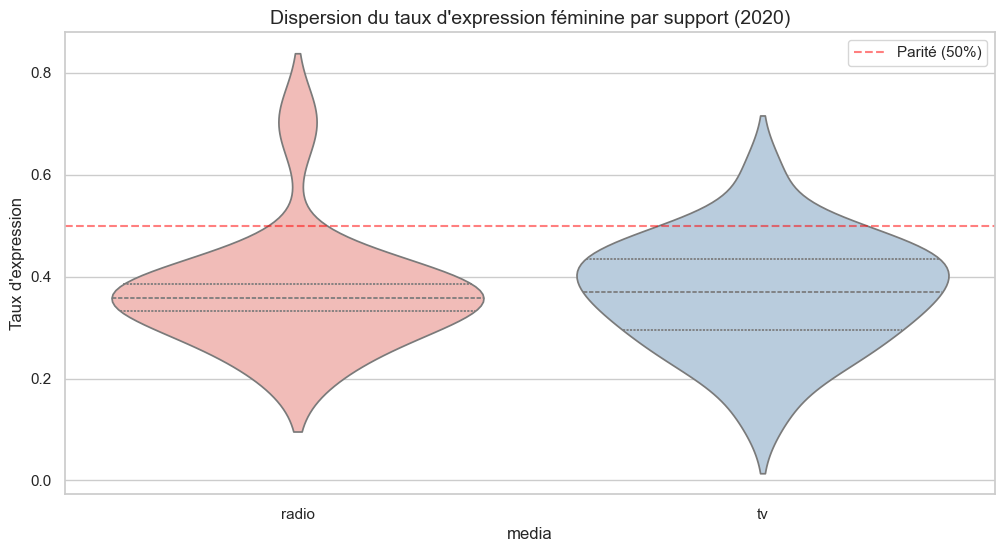

In [23]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_chaines, x='media', y='women_expression_rate_2020', palette="Pastel1", inner="quart")
plt.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Parité (50%)')
plt.title("Dispersion du taux d'expression féminine par support (2020)", fontsize=14)
plt.ylabel("Taux d'expression")
plt.legend()
plt.show()

### **B. La Hiérarchie des Genres de Programmes**
C'est ici que l'analyse devient révélatrice d'une ségrégation thématique. Nous classons les programmes par taux d'expression pour identifier les domaines "ancres" et les domaines "moteurs" de la parité.

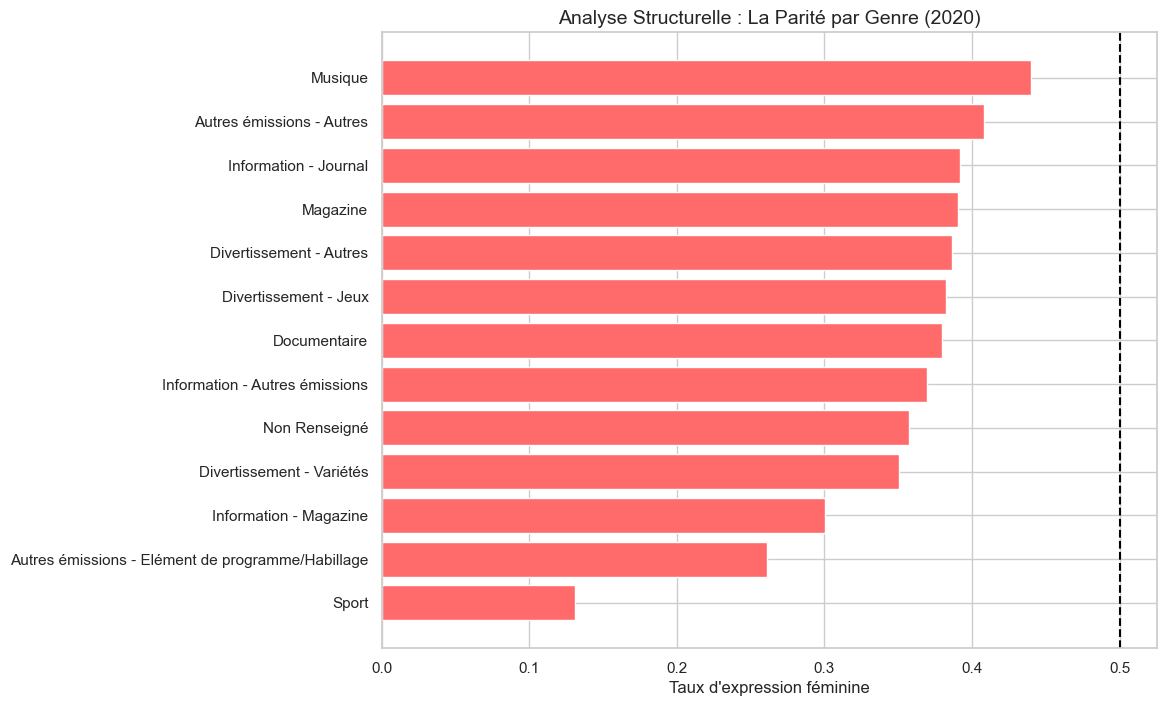

In [25]:
# Tri par performance
df_genres_sorted = df_genres.sort_values('women_expression_rate_2020', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(df_genres_sorted['genre'], df_genres_sorted['women_expression_rate_2020'], color=color_women)
plt.axvline(0.5, color='black', linestyle='--')
plt.title("Analyse Structurelle : La Parité par Genre (2020)", fontsize=14)
plt.xlabel("Taux d'expression féminine")
plt.show()

##  4. Machine Learning
Utilisons la **Régression Linéaire** pour projeter l'avenir. En calculant la vitesse de progression entre 2019 et 2020, nous estimons l'année où la parité réelle (50%) sera mathématiquement atteinte si aucun changement systémique n'intervient.

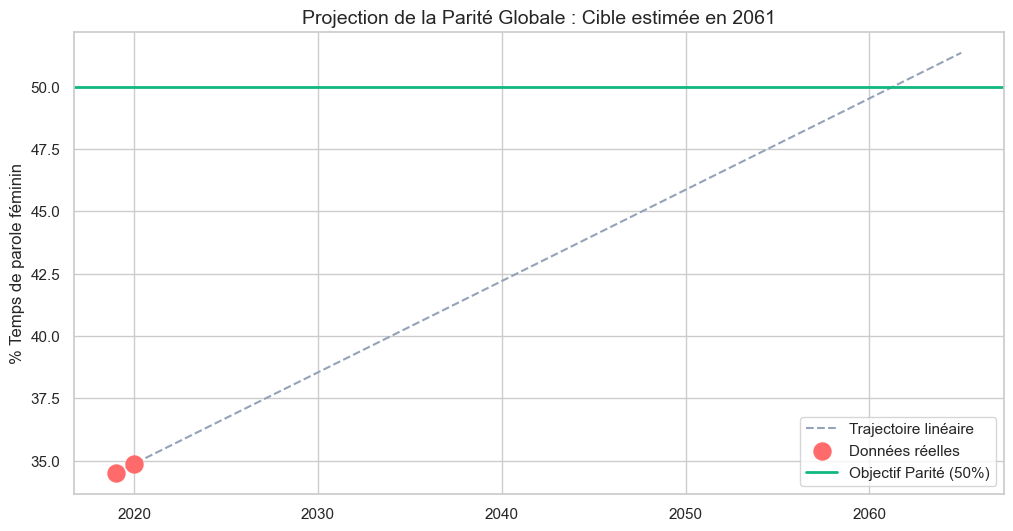

Progression annuelle : +0.37%


In [27]:
# Calcul des taux globaux pondérés par le volume de parole total
def get_global_rate(df, year):
    w_col = f'women_speech_duration_{year}'
    m_col = f'men_speech_duration_{year}'
    return (df[w_col].sum() / (df[w_col].sum() + df[m_col].sum())) * 100

rate_2019 = get_global_rate(df_chaines, 2019)
rate_2020 = get_global_rate(df_chaines, 2020)

# Entraînement du modèle (y = ax + b)
X = np.array([2019, 2020]).reshape(-1, 1)
y = np.array([rate_2019, rate_2020])
model = LinearRegression().fit(X, y)

# Projection vers l'objectif 50%
target_y = 50
target_year = int((target_y - model.intercept_) / model.coef_[0])

# Visualisation de la trajectoire
years_proj = np.arange(2019, target_year + 5).reshape(-1, 1)
preds = model.predict(years_proj)

plt.figure(figsize=(12, 6))
plt.plot(years_proj, preds, color='#94a3b8', linestyle='--', label='Trajectoire linéaire')
plt.scatter(X, y, color=color_women, s=150, zorder=5, label='Données réelles')
plt.axhline(50, color='#10b981', linewidth=2, label='Objectif Parité (50%)')
plt.title(f"Projection de la Parité Globale : Cible estimée en {target_year}", fontsize=14)
plt.ylabel("% Temps de parole féminin")
plt.legend()
plt.show()

print(f"Progression annuelle : +{model.coef_[0]:.2f}%")

In [17]:
top_flop = df_chaines[['media', 'Editeur', 'women_expression_rate_2020']].copy()
top_flop = top_flop.sort_values('women_expression_rate_2020', ascending=False)

def assign_statut(rate):
    if rate >= 0.48: return "✅ Parité atteinte"
    if rate >= 0.35: return "🟠 Moyen"
    return "🛑 Alerte"

top_flop['Statut'] = top_flop['women_expression_rate_2020'].apply(assign_statut)
top_flop.head(10) # Affiche les 10 meilleurs

,media,Editeur,women_expression_rate_2020,Statut
1,radio,Fip,0.703660,✅ Parité atteinte
21,tv,FRANCE 4,0.600495,✅ Parité atteinte
13,tv,6TER,0.479710,🟠 Moyen
22,tv,FRANCE 5,0.472267,🟠 Moyen
26,tv,M6,0.466528,🟠 Moyen
31,tv,TFX,0.464186,🟠 Moyen
19,tv,FRANCE 2,0.436858,🟠 Moyen
23,tv,France 24,0.431546,🟠 Moyen
20,tv,FRANCE 3,0.428972,🟠 Moyen
18,tv,Chérie 25,0.410894,🟠 Moyen


##  Conclusion de l'Analyse Approfondie

L'exploration de ces datasets permet de tirer trois conclusions majeures :

1. **Une inertie alarmante :** La progression annuelle de **+0,43%** montre que la parité n'est pas un processus organique rapide, mais une lente évolution nécessitant des décennies pour aboutir sans intervention.
2. **Le "Poids du Sport" :** Le genre sportif reste le bastion le plus impénétrable, avec un taux d'expression féminine qui pèse négativement sur l'ensemble du paysage médiatique.
3. **Le Réflexe de Crise :** La stagnation observée en 2020 suggère qu'en période de tension, les médias privilégient les réseaux d'experts traditionnels, souvent masculins.

> **Note :** Cette analyse démontre que l'IA et la Data Science sont essentielles pour transformer une impression de diversité en indicateurs mesurables et opposables.